# Illustration of PKPD model for Erlotinib and Gefitinib

Following [[1]]

- [[1]] Eigenmann et. al., Combining Nonclinical Experiments with Translational PKPD Modeling to Differentiate
Erlotinib and Gefitinib

## PK model

The PK model according to [[1]] is defined as

\begin{align}
\frac{\text{d}A_d}{\text{d}t} &= -k_{a}A_d\\
\frac{\text{d}A_p}{\text{d}t} &= k_{a} A_d - k_e A_p\\
C_p &= \frac{A_p}{V},
\end{align}

where $A_i$ is the amount of drug in the dose compartment $i=d$ and in the plasma $i=p$. $C_p$ is the plasma, $V$ the volume of distribution in the plasma, $k_a$ the absorption rate and $k_e$ the elimination rate.

### Computing time-concentration profiles:

In [51]:
import myokit
import numpy as np

# build model
model = myokit.Model()

# add dosing compartment and central compartment
dose_comp = model.add_component('dose')
central_comp = model.add_component('plasma')

# add relevant variables and constants to dose compartment
# (the dose and regimen will be set with an additional dose_rate 
# and regimen variable)
amount_d = dose_comp.add_variable('amount')
k_a = dose_comp.add_variable('k_a')
dose_rate = dose_comp.add_variable('dose_rate')
regimen = dose_comp.add_variable('regimen')

# add relevant variables and constants to central compartment
amount_p = central_comp.add_variable('amount')
volume = central_comp.add_variable('volume')
k_e = central_comp.add_variable('k_e')
conc_p = central_comp.add_variable('drug_concentration')  # to be able to use this with pyqt PKPDApp

# bind time
time = central_comp.add_variable('time')
time.set_binding('time')

# bind regimen to protocol pacer
regimen.set_binding('pace')


# set intial values (some default values)
time.set_rhs(0)

amount_d.set_rhs(0)
k_a.set_rhs(0)
dose_rate.set_rhs(0)
regimen.set_rhs(0)

amount_p.set_rhs(0)
volume.set_rhs(1)
k_e.set_rhs(0)
conc_p.set_rhs(0)

# set units
time.set_unit('day')  # time in days

amount_d.set_unit('mg')  # miligram
k_a.set_unit('1 / day')  # 1 / day
dose_rate.set_unit('mg / day')  # miligram / day
regimen.set_unit(myokit.units.dimensionless)  # dimensionless

amount_p.set_unit('mg')  # miligram
volume.set_unit('L')  # liter
k_e.set_unit('1 / day')  # 1 / day
conc_p.set_unit('mg / L')  # miligram / liter

# set preferred representation of units
# time days
unit = myokit.parse_unit('day')
myokit.Unit.register_preferred_representation('day', unit)
# rates in 1 / day
unit = myokit.parse_unit('1/day')
myokit.Unit.register_preferred_representation('1/day', unit)
# amount in mg
unit = myokit.parse_unit('mg')
myokit.Unit.register_preferred_representation('mg', unit)
# dose rate in mg / day
unit = myokit.parse_unit('mg/day')
myokit.Unit.register_preferred_representation('mg/day', unit)
# concentration mg / L
unit = myokit.parse_unit('mg/L')
myokit.Unit.register_preferred_representation('mg/L', unit)


# set rhs of state variables (dose_rate * regimen - k_a * A_d)
amount_d.promote()
amount_d.set_rhs(
    myokit.Minus(
        myokit.Multiply(myokit.Name(dose_rate), myokit.Name(regimen)),
        myokit.Multiply(myokit.Name(k_a), myokit.Name(amount_d))
    )
)

amount_p.promote()
amount_p.set_rhs(
    myokit.Minus(
        myokit.Multiply(myokit.Name(k_a), myokit.Name(amount_d)),
        myokit.Multiply(myokit.Name(k_e), myokit.Name(amount_p))
    )
)

# set algebraic relation between drug and concentration
conc_p.set_rhs(myokit.Divide(myokit.Name(amount_p), myokit.Name(volume)))

print(model.code(line_numbers=True))
model.check_units(mode=myokit.UNIT_TOLERANT)
model.validate()

1 [[model]]
 2 # Initial values
 3 dose.amount   = 0
 4 plasma.amount = 0
 5 
 6 [dose]
 7 dot(amount) = dose_rate * regimen - k_a * amount
 8     in [mg]
 9 dose_rate = 0
10     in [mg/day]
11 k_a = 0
12     in [1/day]
13 regimen = 0 bind pace
14     in [1]
15 
16 [plasma]
17 dot(amount) = dose.k_a * dose.amount - k_e * amount
18     in [mg]
19 drug_concentration = amount / volume
20     in [mg/L]
21 k_e = 0
22     in [1/day]
23 time = 0 bind time
24     in [day]
25 volume = 1
26     in [L]



### Run simulation for given parameters, dose and regimen

In [23]:
# set parameter values for Erlotinib (according to [1])
k_a.set_rhs(55.0)  # [1 / d]

volume.set_rhs(0.127)  # 0.127 [L]
k_e.set_rhs(7.56)  # 7.56 [1 / d]

# define dosing regimen
duration = 0.001  # [1 / d] how long does it take for dose to be in dosing compartment?
dose_rate.set_rhs(25 * 0.2 / duration)  # 100 mg / kg / d let's estimate weight of mouse 0.2 kg
dosing_regimen = myokit.Protocol()
dosing_regimen.schedule(level=1, start=0, duration=duration)

# run simulation
simulation = myokit.Simulation(model, dosing_regimen)
result = simulation.run(1)

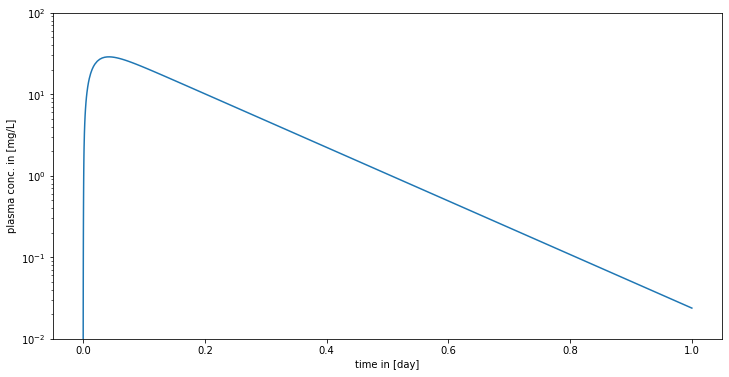

In [24]:
import matplotlib.pyplot as plt

time_key = 'plasma.time'
conc_key = 'plasma.drug_concentration'

time = result[time_key]
drug_conc = result[conc_key]

# plot result
fig = plt.figure(figsize=(12, 6))

# semilog plot
plt.semilogy(time, drug_conc)

# set x and y label
unit = model.get(time_key).unit()
plt.xlabel('time in %s' % str(unit))
unit = model.get(conc_key).unit()
plt.ylabel('plasma conc. in %s' % str(unit))

# set y lim
plt.ylim([0.01,100])

plt.show()

## Target Modulation PKPD (TM/PKPD)

The above PK model is complemented by a target modulation model to model the pErk profiles [[1]].

\begin{align}
C_{\text{pErk}} = C_{\text{pErk},0}\left( 1 - \frac{I_{\text{max}}C_p}{C_{I50}+C_p}\right) ,
\end{align}

where $C_{\text{pErk}}$ is the pErk concentration in the plasma, $C_{\text{pErk},0}$ the pErk base level, $I_{\text{max}}$ the maximal inhibitory effect in units of $C_{\text{pErk},0}$, and $C_{I50}$ the concentration where half of the inhibitory effect is achieved.

### Time-concentration profile of plasma drud and plasma pErk

In [52]:
import myokit
import numpy as np

# build model
model = myokit.Model()

# add dosing compartment and central compartment
dose_comp = model.add_component('dose')
central_comp = model.add_component('plasma')

# add relevant variables and constants to dose compartment
# (the dose and regimen will be set with an additional dose_rate 
# and regimen variable)
amount_d = dose_comp.add_variable('amount')
k_a = dose_comp.add_variable('k_a')
dose_rate = dose_comp.add_variable('dose_rate')
regimen = dose_comp.add_variable('regimen')

# add PK variables to central compartment
amount_p = central_comp.add_variable('amount')
volume = central_comp.add_variable('volume')
k_e = central_comp.add_variable('k_e')
conc_p = central_comp.add_variable('drug_concentration')  # to be able to use this with pyqt PKPDApp

# add PD variables to central compartment
conc_perk = central_comp.add_variable('pErk_concentration')
initial_perk = central_comp.add_variable('init_pErk')
i_max = central_comp.add_variable('i_max')
ic_50 = central_comp.add_variable('ic_50')

# bind time
time = central_comp.add_variable('time')
time.set_binding('time')

# bind regimen to protocol pacer
regimen.set_binding('pace')


# set intial values (some default values)
time.set_rhs(0)

amount_d.set_rhs(0)
k_a.set_rhs(0)
dose_rate.set_rhs(0)
regimen.set_rhs(0)

amount_p.set_rhs(0)
volume.set_rhs(1)
k_e.set_rhs(0)
conc_p.set_rhs(0)

conc_perk.set_rhs(0)
initial_perk.set_rhs(0)
i_max.set_rhs(0)
ic_50.set_rhs(1)

# set units
time.set_unit('day')  # time in days

amount_d.set_unit('mg')  # miligram
k_a.set_unit('1 / day')  # 1 / day
dose_rate.set_unit('mg / day')  # miligram / day
regimen.set_unit(myokit.units.dimensionless)  # dimensionless

amount_p.set_unit('mg')  # miligram
volume.set_unit('L')  # liter
k_e.set_unit('1 / day')  # 1 / day
conc_p.set_unit('mg / L')  # miligram / liter

conc_perk.set_unit('pg / mL')  # picogram
initial_perk.set_unit('pg / mL')  # picogram
i_max.set_unit(myokit.units.dimensionless)  # dimensionless
ic_50.set_unit('mg / L')  # miligram / liter

# set preferred representation of units
# time days
unit = myokit.parse_unit('day')
myokit.Unit.register_preferred_representation('day', unit)
# rates in 1 / day
unit = myokit.parse_unit('1/day')
myokit.Unit.register_preferred_representation('1/day', unit)
# amount in mg
unit = myokit.parse_unit('mg')
myokit.Unit.register_preferred_representation('mg', unit)
# dose rate in mg / day
unit = myokit.parse_unit('mg/day')
myokit.Unit.register_preferred_representation('mg/day', unit)
# drug concentration mg / L
unit = myokit.parse_unit('mg/L')
myokit.Unit.register_preferred_representation('mg/L', unit)
# pErk concentration mg / L
unit = myokit.parse_unit('pg/mL')
myokit.Unit.register_preferred_representation('pg/mL', unit)


# set rhs of state variables (dose_rate * regimen - k_a * A_d)
amount_d.promote()
amount_d.set_rhs(
    myokit.Minus(
        myokit.Multiply(myokit.Name(dose_rate), myokit.Name(regimen)),
        myokit.Multiply(myokit.Name(k_a), myokit.Name(amount_d))
    )
)

amount_p.promote()
amount_p.set_rhs(
    myokit.Minus(
        myokit.Multiply(myokit.Name(k_a), myokit.Name(amount_d)),
        myokit.Multiply(myokit.Name(k_e), myokit.Name(amount_p))
    )
)

# set algebraic equation
# drug and concentration
conc_p.set_rhs(myokit.Divide(myokit.Name(amount_p), myokit.Name(volume)))
# pErk concentration
conc_perk.set_rhs(myokit.Multiply(
    myokit.Name(initial_perk),
    myokit.Minus(
        myokit.Number(1),
        myokit.Divide(
            myokit.Multiply(myokit.Name(i_max), myokit.Name(conc_p)),
            myokit.Plus(myokit.Name(ic_50), myokit.Name(conc_p))
        )
    )
))

print(model.code(line_numbers=True))
model.check_units(mode=myokit.UNIT_TOLERANT)
model.validate()

1 [[model]]
 2 # Initial values
 3 dose.amount   = 0
 4 plasma.amount = 0
 5 
 6 [dose]
 7 dot(amount) = dose_rate * regimen - k_a * amount
 8     in [mg]
 9 dose_rate = 0
10     in [mg/day]
11 k_a = 0
12     in [1/day]
13 regimen = 0 bind pace
14     in [1]
15 
16 [plasma]
17 dot(amount) = dose.k_a * dose.amount - k_e * amount
18     in [mg]
19 drug_concentration = amount / volume
20     in [mg/L]
21 i_max = 0
22     in [1]
23 ic_50 = 1
24     in [mg/L]
25 init_pErk = 0
26     in [pg/mL]
27 k_e = 0
28     in [1/day]
29 pErk_concentration = init_pErk * (1 - i_max * drug_concentration / (ic_50 + drug_concentration))
30     in [pg/mL]
31 time = 0 bind time
32     in [day]
33 volume = 1
34     in [L]



### Run simulation for given parameters, dose and regimen

In [38]:
# set parameter values for Erlotinib (according to [1] Sup. Table S2)
k_a.set_rhs(55.0)  # [1 / d]

volume.set_rhs(0.326)  # [L]
k_e.set_rhs(4.47)  # [1 / d]

initial_perk.set_rhs(668)
i_max.set_rhs(0.72)
ic_50.set_rhs(0.513)

# define dosing regimen
duration = 0.001  # [1 / d] how long does it take for dose to be in dosing compartment?
dose_rate.set_rhs(25 * 0.2 / duration)  # 100 mg / kg / d let's estimate weight of mouse 0.2 kg
dosing_regimen = myokit.Protocol()
dosing_regimen.schedule(level=1, start=0, duration=duration)

# run simulation
simulation = myokit.Simulation(model, dosing_regimen)
result = simulation.run(1)

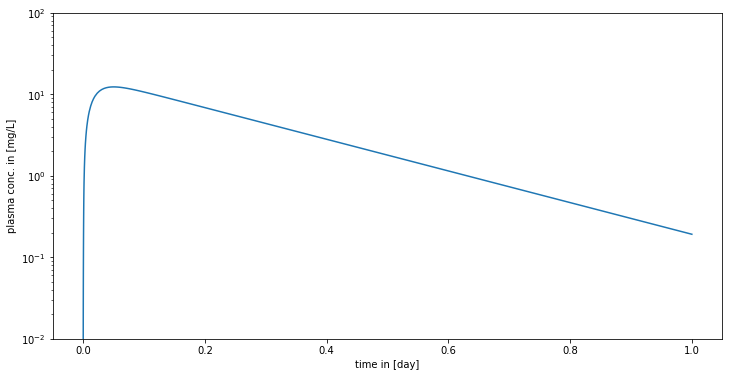

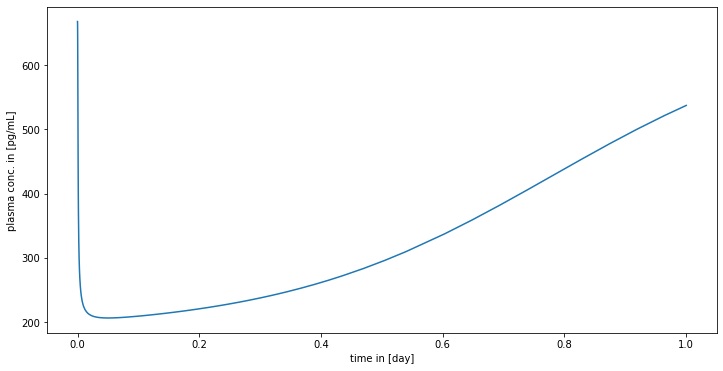

In [39]:
import matplotlib.pyplot as plt

time_key = 'plasma.time'
conc_key = 'plasma.drug_concentration'
pErk_key = 'plasma.pErk_concentration'

time = result[time_key]
drug_conc = result[conc_key]
pErk_conc = result[pErk_key]

# plot drug time-concentration curve
fig = plt.figure(figsize=(12, 6))

# semilog plot
plt.semilogy(time, drug_conc)

# set x and y label
unit = model.get(time_key).unit()
plt.xlabel('time in %s' % str(unit))
unit = model.get(conc_key).unit()
plt.ylabel('plasma conc. in %s' % str(unit))

# set y lim
plt.ylim([0.01,100])

plt.show()

# plot pErk time-concentration curve
fig = plt.figure(figsize=(12, 6))

# semilog plot
plt.plot(time, pErk_conc)

# set x and y label
unit = model.get(time_key).unit()
plt.xlabel('time in %s' % str(unit))
unit = model.get(pErk_key).unit()
plt.ylabel('pErk conc. in %s' % str(unit))

plt.show()

## Tumor Growth Inhibition PKPD (TGI/PKPD)

The above PK model is complemented by a tumor growth inhibition model to model the tumor volume over time [[1]].

\begin{align}
\frac{\text{d}V_T}{\text{d}t} = \frac{2\lambda _0\lambda _1 V_T}{2\lambda _0 V_T + \lambda _1} - \kappa C_pV_T,
\end{align}

where $V_T$ is the volume of the tumor, $\lambda _0 $ the exponential and $\lambda _1$ the linear growth rate. $\kappa $ represents the potency of the compound. 

### Time-concentration profile of plasma drug and tumor volume

In [1]:
import myokit
import numpy as np

# build model
model = myokit.Model()

# add dosing compartment and central compartment
dose_comp = model.add_component('dose')
central_comp = model.add_component('plasma')

# add relevant variables and constants to dose compartment
# (the dose and regimen will be set with an additional dose_rate 
# and regimen variable)
amount_d = dose_comp.add_variable('amount')
k_a = dose_comp.add_variable('k_a')
dose_rate = dose_comp.add_variable('dose_rate')
regimen = dose_comp.add_variable('regimen')

# add PK variables to central compartment
amount_p = central_comp.add_variable('amount')
volume_p = central_comp.add_variable('volume_plasma')
k_e = central_comp.add_variable('k_e')
conc_p = central_comp.add_variable('drug_concentration')  # to be able to use this with pyqt PKPDApp

# add PD variables to central compartment
volume_T = central_comp.add_variable('volume_tumor')
lambda_0 = central_comp.add_variable('lambda_0')
lambda_1 = central_comp.add_variable('lambda_1')
kappa = central_comp.add_variable('kappa')

# bind time
time = central_comp.add_variable('time')
time.set_binding('time')

# bind regimen to protocol pacer
regimen.set_binding('pace')


# set intial values (some default values)
time.set_rhs(0)

amount_d.set_rhs(0)
k_a.set_rhs(0)
dose_rate.set_rhs(0)
regimen.set_rhs(0)

amount_p.set_rhs(0)
volume_p.set_rhs(1)
k_e.set_rhs(0)
conc_p.set_rhs(0)

volume_T.set_rhs(0)
lambda_0.set_rhs(0)
lambda_1.set_rhs(1)  # avoid dividing by zero
kappa.set_rhs(0)

# set units
time.set_unit('day')  # time in days

amount_d.set_unit('mg')  # miligram
k_a.set_unit('1 / day')  # 1 / day
dose_rate.set_unit('mg / day')  # miligram / day
regimen.set_unit(myokit.units.dimensionless)  # dimensionless

amount_p.set_unit('mg')  # miligram
volume_p.set_unit('L')  # liter
k_e.set_unit('1 / day')  # 1 / day
conc_p.set_unit('mg / L')  # miligram / liter

volume_T.set_unit('mm^3')  # milimeter cubed
lambda_0.set_unit('1 / day')  # per day
lambda_1.set_unit('mm^3 / day')  # milimiter cubed per day
kappa.set_unit('L / mg / day')  # in reference L / ug / day, 
# so values here are 10^3 larger.

# set preferred representation of units
# time days
unit = myokit.parse_unit('day')
myokit.Unit.register_preferred_representation('day', unit)
# rates in 1 / day
unit = myokit.parse_unit('1/day')
myokit.Unit.register_preferred_representation('1/day', unit)
# amount in mg
unit = myokit.parse_unit('mg')
myokit.Unit.register_preferred_representation('mg', unit)
# dose rate in mg / day
unit = myokit.parse_unit('mg/day')
myokit.Unit.register_preferred_representation('mg/day', unit)
# drug concentration mg / L
unit = myokit.parse_unit('mg/L')
myokit.Unit.register_preferred_representation('mg/L', unit)
# tumor volume
unit = myokit.parse_unit('mm^3')
myokit.Unit.register_preferred_representation('mm^3', unit)
# linear growth
unit = myokit.parse_unit('mm^3/day')
myokit.Unit.register_preferred_representation('mm^3/day', unit)
# potency
unit = myokit.parse_unit('L/mg/day')
myokit.Unit.register_preferred_representation('L/mg/day', unit)

# set rhs of state variables (dose_rate * regimen - k_a * A_d)
amount_d.promote()
amount_d.set_rhs(
    myokit.Minus(
        myokit.Multiply(myokit.Name(dose_rate), myokit.Name(regimen)),
        myokit.Multiply(myokit.Name(k_a), myokit.Name(amount_d))
    )
)

amount_p.promote()
amount_p.set_rhs(
    myokit.Minus(
        myokit.Multiply(myokit.Name(k_a), myokit.Name(amount_d)),
        myokit.Multiply(myokit.Name(k_e), myokit.Name(amount_p))
    )
)

volume_T.promote()
volume_T.set_rhs(
    myokit.Minus(
        myokit.Divide(
            myokit.Multiply(
                myokit.Number(2),
                myokit.Multiply(
                    myokit.Name(lambda_0),
                    myokit.Multiply(
                        myokit.Name(lambda_1),
                        myokit.Name(volume_T)
                    )
                )
            ),
            myokit.Plus(
                myokit.Multiply(
                    myokit.Number(2),
                    myokit.Multiply(
                        myokit.Name(lambda_0),
                        myokit.Name(volume_T)
                    )
                ),
                myokit.Name(lambda_1)
            )
        ),
        myokit.Multiply(
            myokit.Name(kappa),
            myokit.Multiply(
                myokit.Name(conc_p),
                myokit.Name(volume_T)
            )
        )
    )
)

# set algebraic equation
# drug and concentration
conc_p.set_rhs(myokit.Divide(myokit.Name(amount_p), myokit.Name(volume_p)))

print(model.code(line_numbers=True))
model.check_units(mode=myokit.UNIT_TOLERANT)
model.validate()

1 [[model]]
 2 # Initial values
 3 dose.amount         = 0
 4 plasma.amount       = 0
 5 plasma.volume_tumor = 0
 6 
 7 [dose]
 8 dot(amount) = dose_rate * regimen - k_a * amount
 9     in [mg]
10 dose_rate = 0
11     in [mg/day]
12 k_a = 0
13     in [1/day]
14 regimen = 0 bind pace
15     in [1]
16 
17 [plasma]
18 dot(amount) = dose.k_a * dose.amount - k_e * amount
19     in [mg]
20 drug_concentration = amount / volume_plasma
21     in [mg/L]
22 k_e = 0
23     in [1/day]
24 kappa = 0
25     in [L/mg/day]
26 lambda_0 = 0
27     in [1/day]
28 lambda_1 = 1
29     in [mm^3/day]
30 time = 0 bind time
31     in [day]
32 volume_plasma = 1
33     in [L]
34 dot(volume_tumor) = 2 * (lambda_0 * (lambda_1 * volume_tumor)) / (2 * (lambda_0 * volume_tumor) + lambda_1) - kappa * (drug_concentration * volume_tumor)
35     in [mm^3]



### Run simulation for given parameters, dose and regimen (Erlotinib, A677)

In [4]:
# set parameter values for Erlotinib (according to [1] Sup. Table S2)
k_a.set_rhs(55.0)  # [1 / d]

volume_p.set_rhs(0.127)  # [L]
k_e.set_rhs(7.56)  # [1 / d]

volume_T.set_state_value(122)  # mm^3
lambda_0.set_rhs(0.0971)  # per day
lambda_1.set_rhs(127)  # mm^3 / day
kappa.set_rhs(0.117)  # L / mg / day 

# define dosing regimen
duration = 0.001  # [1 / d] how long does it take for dose to be in dosing compartment?
dose_rate.set_rhs(100 * 0.2 / duration)  # 100 mg / kg / d let's estimate weight of mouse 0.2 kg
dosing_regimen = myokit.Protocol()
dosing_regimen.schedule(level=1, start=2, duration=duration, period=1, multiplier=15)

# run simulation
simulation = myokit.Simulation(model, dosing_regimen)
result = simulation.run(30)

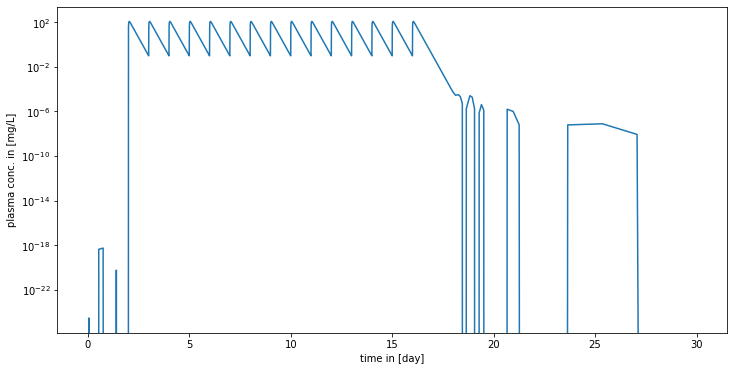

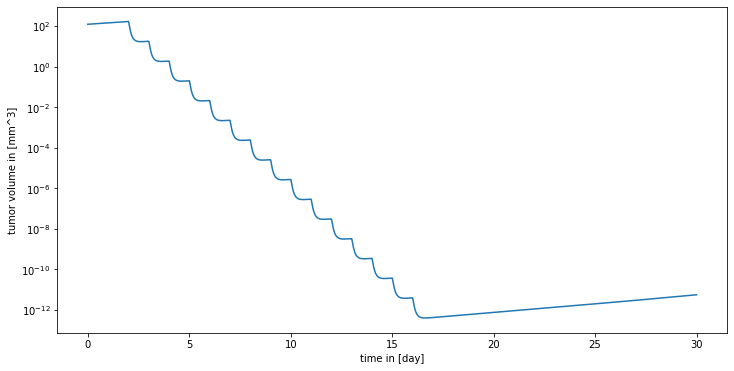

In [5]:
import matplotlib.pyplot as plt

time_key = 'plasma.time'
conc_key = 'plasma.drug_concentration'
tumor_key = 'plasma.volume_tumor'

time = result[time_key]
drug_conc = result[conc_key]
volume_tumor = result[tumor_key]

# plot drug time-concentration curve
fig = plt.figure(figsize=(12, 6))

# semilog plot
plt.semilogy(time, drug_conc)

# set x and y label
unit = model.get(time_key).unit()
plt.xlabel('time in %s' % str(unit))
unit = model.get(conc_key).unit()
plt.ylabel('plasma conc. in %s' % str(unit))

# # set y lim
# plt.ylim([0.01,100])

plt.show()

# plot time-tumor volume curve
fig = plt.figure(figsize=(12, 6))

# semilog plot
plt.semilogy(time, volume_tumor)

# set x and y label
unit = model.get(time_key).unit()
plt.xlabel('time in %s' % str(unit))
unit = model.get(tumor_key).unit()
plt.ylabel('tumor volume in %s' % str(unit))

plt.show()